# Importing

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torch.optim as optim
import copy
import zipfile


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading Dataset

In [ ]:
!unrar x "./drive/My Drive/alter_real_detect_data/alter_real_detect_data.rar" 

In [30]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [31]:
trainset = torchvision.datasets.ImageFolder('./alter_real_detect_data/alter_detect_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./alter_real_detect_data/alter_detect_test',transform = transform)

In [32]:
trainset.class_to_idx

{'altered': 0, 'real': 1}

In [33]:
testset.class_to_idx

{'altered': 0, 'real': 1}

In [34]:
torch.unique(torch.tensor(trainset.targets), return_counts=True)

(tensor([0, 1]), tensor([4514, 4487]))

In [35]:
torch.unique(torch.tensor(testset.targets), return_counts=True)

(tensor([0, 1]), tensor([1500, 1513]))

In [ ]:
!ls -a './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test'

.  ..  Altered	Real


In [ ]:
!rm -r './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test/.ipynb_checkpoints'

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)

# Architectures

## Inception_v3 Architecture

In [ ]:
inception = model.inception_v3(pretrained= True)
print(inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, 2)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 768])
torch.Size([2])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, 2)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 768])
torch.Size([2])
torch.Size([2, 2048])
torch.Size([2])


In [ ]:
for param in inception.Conv2d_1a_3x3.parameters():
  param.requires_grad = True
for param in inception.Conv2d_2a_3x3.parameters():
  param.requires_grad = True

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([2, 768])
torch.Size([2])
torch.Size([2, 2048])
torch.Size([2])


In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
inception = inception.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(inception.parameters(), lr=0.0001)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)


In [ ]:
loss_epoch_arr = []
max_epochs = 10

min_loss = 1000

#n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 400 == 0:
            print('Iteration: %d, Loss: %0.2f' % (i,  loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
  
    
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
    epoch, max_epochs, 
    evaluation_inception(testloader, inception), 
    evaluation_inception(trainloader, inception)))

    
plt.plot(loss_epoch_arr)
plt.show()

Min loss 0.91
Iteration: 0, Loss: 0.91
Min loss 0.90
Min loss 0.85
Min loss 0.76
Min loss 0.75
Epoch: 0/10, Test acc: 52.03, Train acc: 57.11
Iteration: 0, Loss: 0.83
Min loss 0.73
Iteration: 0, Loss: 0.82
Min loss 0.70
Iteration: 0, Loss: 0.81
Min loss 0.70
Min loss 0.68
Min loss 0.67
Iteration: 0, Loss: 0.81
Min loss 0.66
Iteration: 0, Loss: 0.71
Min loss 0.65
Min loss 0.65
Min loss 0.60
Epoch: 5/10, Test acc: 49.32, Train acc: 67.72
Iteration: 0, Loss: 0.98
Iteration: 0, Loss: 0.74


KeyboardInterrupt: ignored

## AlexNet

In [36]:
alex_net = model.alexnet(pretrained=True)
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
for param in alex_net.parameters():
  param.requires_grad = False

  

In [38]:
in_features = alex_net.classifier[6].in_features
alex_net.classifier[6] = nn.Linear(in_features,4)

In [39]:
for param in alex_net.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([4, 4096])
torch.Size([4])


In [40]:
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [41]:
for param in alex_net.features[3:9].parameters():
  param.requires_grad = True


In [42]:
for param in alex_net.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([4, 4096])
torch.Size([4])


In [43]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [44]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


Epoch:1: Iteration 0/400: Loss: 1.6625858545303345
Epoch:0/10: The Train Accuracy: 92.9007888012443 . The Test Accuracy: 97.67673415200797
Epoch:2: Iteration 0/400: Loss: 0.18249782919883728
Epoch:1/10: The Train Accuracy: 95.71158760137763 . The Test Accuracy: 98.53966146697644
Epoch:3: Iteration 0/400: Loss: 0.1311313658952713
Epoch:2/10: The Train Accuracy: 97.26697033662926 . The Test Accuracy: 98.20776634583471
Epoch:4: Iteration 0/400: Loss: 0.06414124369621277
Epoch:3/10: The Train Accuracy: 97.6780357738029 . The Test Accuracy: 98.73879853966147
Epoch:5: Iteration 0/400: Loss: 0.04304758086800575
Epoch:4/10: The Train Accuracy: 98.0002221975336 . The Test Accuracy: 98.00862927314968
Epoch:6: Iteration 0/400: Loss: 0.09485889226198196
Epoch:5/10: The Train Accuracy: 99.18897900233307 . The Test Accuracy: 97.54397610355127
Epoch:7: Iteration 0/400: Loss: 0.013987617567181587
Epoch:6/10: The Train Accuracy: 99.51116542606377 . The Test Accuracy: 97.84268171257882
Epoch:8: Iteratio

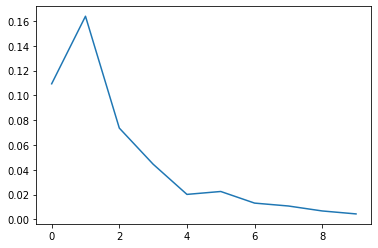

In [45]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

alex_net = alex_net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(alex_net.parameters(),lr = 0.0001,betas=(0.7,0.9))
fit(10,loss_fn,opt,alex_net)

## VGG

In [ ]:
vgg = model.vgg16_bn(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
for param in vgg.features[3:12].parameters():
  param.requires_grad = True

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, 2)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([2, 4096])
torch.Size([2])


In [ ]:
vgg = vgg.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(), lr=0.0005)
fit(20,loss_fn,opt,vgg)

Epoch:1: Iteration 0/400: Loss: 9.352944374084473
Epoch:1: Iteration 100/400: Loss: 5.228086948394775
Epoch:0/20: The Train Accuracy: 64.68032278088144 . The Test Accuracy: 53.09477756286267
Epoch:2: Iteration 0/400: Loss: 10.78887939453125
Epoch:2: Iteration 100/400: Loss: 11.340219497680664
Epoch:1/20: The Train Accuracy: 63.93544382371198 . The Test Accuracy: 50.67698259187621
Epoch:3: Iteration 0/400: Loss: 3.998809576034546


KeyboardInterrupt: ignored

## ResNet-18

In [ ]:
resnet = model.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 2)

In [ ]:
for param in resnet.layer1.parameters():
  param.requires_grad = True

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([2, 512])
torch.Size([2])


In [ ]:
resnet = resnet.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.00001)
fit(25,loss_fn,opt,resnet)

Epoch:1: Iteration 0/400: Loss: 0.6050622463226318
Epoch:1: Iteration 100/400: Loss: 0.6929619312286377
Epoch:0/25: The Train Accuracy: 57.72811918063315 . The Test Accuracy: 51.25725338491296
Epoch:2: Iteration 0/400: Loss: 0.7462477684020996
Epoch:2: Iteration 100/400: Loss: 0.7245017290115356
Epoch:1/25: The Train Accuracy: 59.96275605214153 . The Test Accuracy: 50.38684719535783
Epoch:3: Iteration 0/400: Loss: 0.6348681449890137
Epoch:3: Iteration 100/400: Loss: 0.7174380421638489
Epoch:2/25: The Train Accuracy: 62.94227188081937 . The Test Accuracy: 50.58027079303675
Epoch:4: Iteration 0/400: Loss: 0.6696520447731018
Epoch:4: Iteration 100/400: Loss: 0.6532889604568481
Epoch:3/25: The Train Accuracy: 64.3699565487275 . The Test Accuracy: 50.58027079303675
Epoch:5: Iteration 0/400: Loss: 0.6217666268348694
Epoch:5: Iteration 100/400: Loss: 0.7059926986694336
Epoch:4/25: The Train Accuracy: 66.54252017380509 . The Test Accuracy: 50.483558994197296
Epoch:6: Iteration 0/400: Loss: 0.6

KeyboardInterrupt: ignored

# MobileNet

In [ ]:
mobilenet = model.mobilenet_v2(pretrained = True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
for param in mobilenet.parameters():
  param.requires_grad = False

  

In [ ]:
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features,2)

In [ ]:
for param in mobilenet.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([2, 1280])
torch.Size([2])


In [ ]:
for param in mobilenet.features[0:2].parameters():
  param.requires_grad = True


In [ ]:
for param in mobilenet.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([2, 1280])
torch.Size([2])


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

mobilenet = mobilenet.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(mobilenet.parameters(),lr = 0.01)
fit(30,loss_fn,opt,mobilenet)

Epoch:1: Iteration 0/400: Loss: 0.691527783870697
Epoch:0/30: The Train Accuracy: 70.2048417132216 . The Test Accuracy: 49.806576402321085
Epoch:2: Iteration 0/400: Loss: 0.5618043541908264


KeyboardInterrupt: ignored

# AkaNet

In [78]:
class AkaNet(nn.Module):
  
  def __init__(self):
    
    super(AkaNet,self).__init__()

    self.model_cnn = nn.Sequential(
        nn.Conv2d(3,6,3), #(N,1,224,224) --> (N,6,222,222)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,6,222,222) -->(N,6,111,111)
        nn.Conv2d(6,16,5), #(N,6,111,111)  --> (N,16,107,107)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,16,107,107) --> (N,16,53,53)
        
    )

    self.model_fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(44944,120),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(120,60),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(60,20),
        nn.ReLU(),
        nn.Linear(20,4) 
    )

  def forward(self,x):
    x = self.model_cnn(x)
    x = x.view(x.size(0),-1)
    x = self.model_fc(x)
    return x


In [79]:
net = AkaNet()

In [80]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [81]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [82]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [86]:
trainset = torchvision.datasets.ImageFolder('./types_data/types_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./types_data/types_test',transform = transform)

In [87]:
trainset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [88]:
testset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [89]:
net = AkaNet()


Epoch:1: Iteration 0/400: Loss: 0.9727107882499695
Epoch:0/20: The Train Accuracy: 47.24068798142872 . The Test Accuracy: 50.0
Epoch:2: Iteration 0/400: Loss: 1.0033795833587646
Epoch:1/20: The Train Accuracy: 64.46132742429039 . The Test Accuracy: 61.34615384615385
Epoch:3: Iteration 0/400: Loss: 0.7222885489463806
Epoch:2/20: The Train Accuracy: 69.1358024691358 . The Test Accuracy: 70.61538461538461
Epoch:4: Iteration 0/400: Loss: 0.6153252124786377
Epoch:3/20: The Train Accuracy: 77.21852907038092 . The Test Accuracy: 73.57692307692308
Epoch:5: Iteration 0/400: Loss: 0.5251808762550354
Epoch:4/20: The Train Accuracy: 42.46069431254617 . The Test Accuracy: 49.53846153846154
Epoch:6: Iteration 0/400: Loss: 18.052902221679688
Epoch:5/20: The Train Accuracy: 73.98965917484436 . The Test Accuracy: 68.15384615384616
Epoch:7: Iteration 0/400: Loss: 0.564719557762146
Epoch:6/20: The Train Accuracy: 84.06668777039147 . The Test Accuracy: 74.34615384615384
Epoch:8: Iteration 0/400: Loss: 0.4

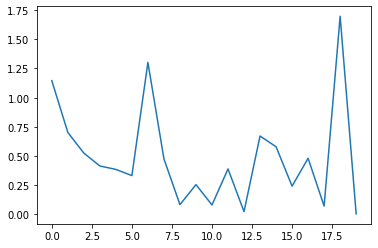

In [91]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

net = net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr=0.01,betas=(0.7,0.9))
fit(20,loss_fn,opt,net)

# Confusion Matrix

In [46]:

def get_outputs(dataloader,model):
  
  y_pred = []
  y_true = []
  for data in dataloader:

    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    y_true.append(labels.squeeze().flatten().tolist())
    y_pred.append(pred.squeeze().flatten().tolist())

  return y_pred,y_true

In [47]:
y_pred,y_true = get_outputs(testloader,alex_net)

In [48]:
import itertools
y_pred = list(itertools.chain(*y_pred))
y_true = list(itertools.chain(*y_true))


In [49]:
print(len(y_pred),len(y_true))

3013 3013


In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1500
           1       0.99      0.98      0.98      1513

    accuracy                           0.98      3013
   macro avg       0.98      0.98      0.98      3013
weighted avg       0.98      0.98      0.98      3013



In [52]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))

[[1491    9]
 [  37 1476]]
